In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
plt.rcParams['figure.figsize'] = (16, 12)

# Cruise Ship Crew Requirements

You've been given a dataset describing various features of cruise ships such as their tonnage, total number of passengers, number of cabins etc. You've been asked to explore the dataset, present some summary statistics and (hopefully) build a model to calculate the number of crew required to staff a new ship. Again, you are asked to break the problem down into three stages

### Part 1: Exploration and Cleaning
1. Read in this data, clean and tidy it etc.
1. Calculate basic statistics to understand what you have been given
1. Select some columns which might be correlated with price

### Part 2: Analysis and Model Building
1. Quantify correlations between columns
1. Create training and testing sets
1. Fit a model to predict crew requirements for new ships

### Part 3: Results
1. Summarize your findings

In [5]:
sCSV = 'https://m2pi.syzygy.ca/data/cruise_ship_info.csv'

sDF = pd.read_csv(sCSV)

In [6]:
sDF.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


Take a look at the numerical columns

In [7]:
sDF.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


In [8]:
sDF.isna().sum(axis=0)

Ship_name            0
Cruise_line          0
Age                  0
Tonnage              0
passengers           0
length               0
cabins               0
passenger_density    0
crew                 0
dtype: int64

In [9]:
sDF.dtypes

Ship_name             object
Cruise_line           object
Age                    int64
Tonnage              float64
passengers           float64
length               float64
cabins               float64
passenger_density    float64
crew                 float64
dtype: object

I'm going to throw away the `Ship_name` then `Cruise_line` is my only categorical column, the rest are numeric. Let's explore the numeric ones

In [10]:
sDF.drop('Ship_name', axis=1, inplace=True)

### Distributions

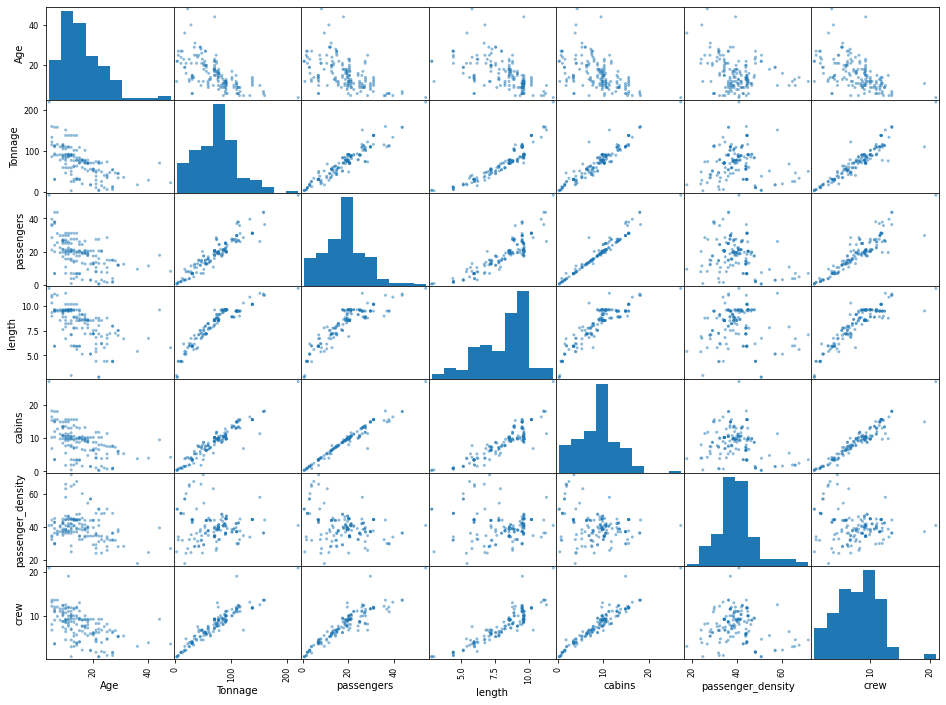

In [13]:
from pandas.plotting import scatter_matrix
cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins','passenger_density','crew']
scatter_matrix(sDF);

**LOTS** of really nice correlation

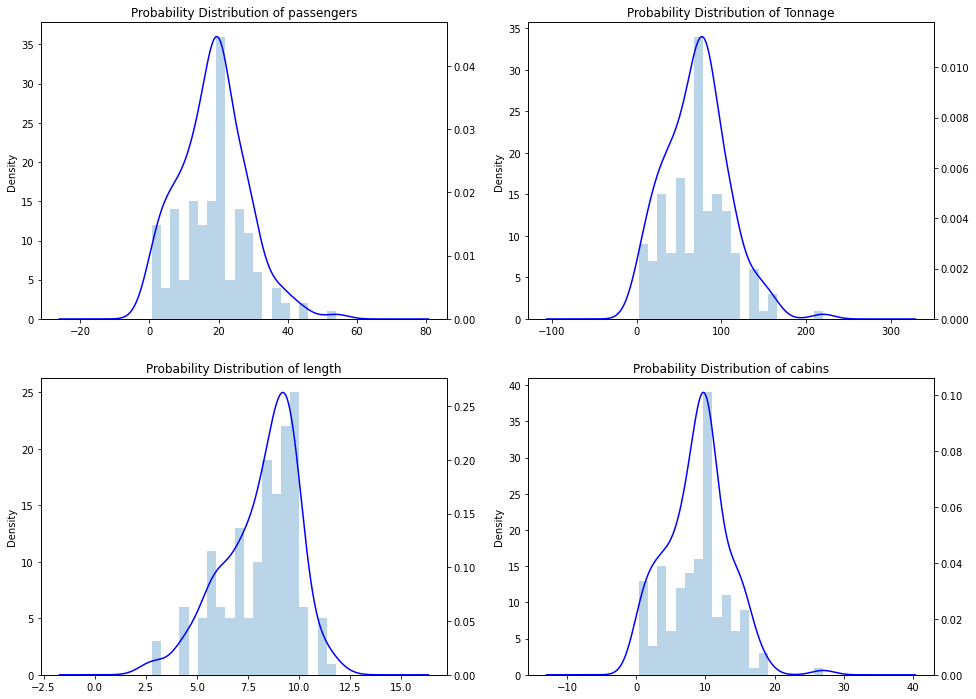

In [14]:
fig, axes = plt.subplots(2, 2)

features = ['passengers', 'Tonnage', 'length', 'cabins']

for i, feature in enumerate(features):
    ax = axes[i // 2, i % 2]
    sDF[feature].plot.hist(ax = ax, bins=20, alpha=0.3)
    sDF[feature].plot.kde(ax = ax, secondary_y=True, color='blue')
    ax.set_ylim(0)
    ax.right_ax.set_ylim(0)
    ax.set_title(f"Probability Distribution of {feature}")

The main conclusion I drew from these was that they were "normalish", I'd probably want to scale them, but other than that I was happy

### Correlations

Next I want to get a quick idea of which variables are correlated with each other

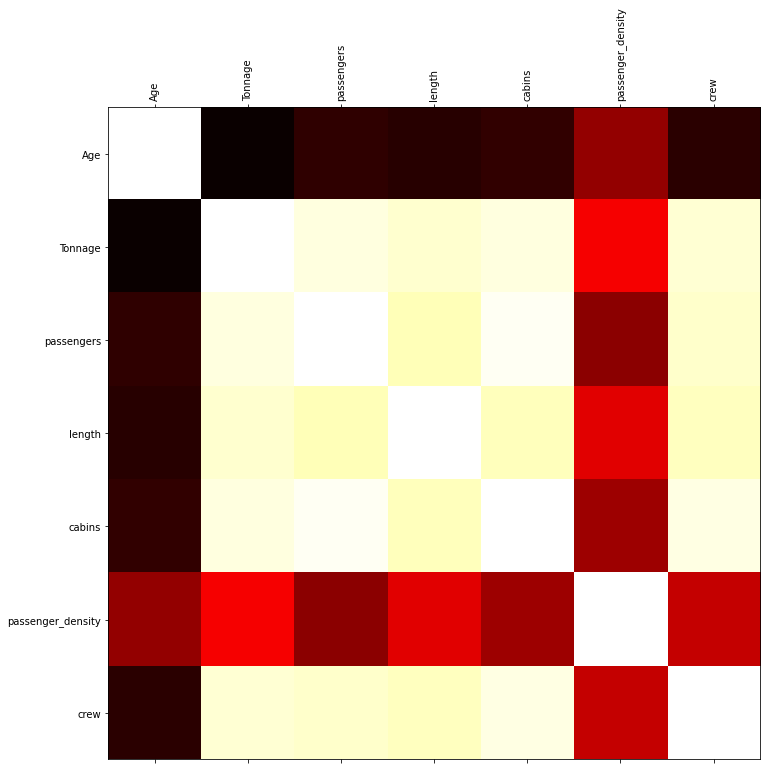

In [15]:
cor = sDF.corr()

fig, ax = plt.subplots()
ax.matshow(
    cor,
    cmap='hot'
)
ax.set_xticks(np.arange(len(cor.columns)));
ax.set_xticklabels(cor.columns, rotation=90);
ax.set_yticks(np.arange(len(cor.columns)));
ax.set_yticklabels(cor.columns);

In [16]:
sDF.cov()['crew']

Age                  -14.158696
Tonnage              120.985762
passengers            31.029706
length                 5.629035
cabins                14.895159
passenger_density     -4.706859
crew                  12.274418
Name: crew, dtype: float64

In [17]:
sDF.corr()['crew']

Age                 -0.530657
Tonnage              0.927569
passengers           0.915234
length               0.895857
cabins               0.950823
passenger_density   -0.155509
crew                 1.000000
Name: crew, dtype: float64

So crew size is strongly correlated with Tonnage, Passengers, length, and cabins

## Splitting the test and training data

If `Tonnage`, `Passengers`, `length` or `cabins` had a non-normal distribution, I would try to make sure that when we split the test and training data, we respect those distributions. `StratifiedShuffleSplit` can take the distribution into account when doing that sampling. Fortunately, those 4 columns look pretty normal so we'll just proceed

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sDF.drop('crew', axis=1), 
    sDF['crew'], 
    test_size=0.2, 
    random_state=0
)

In [19]:
print(X_train.shape, X_test.shape)


(126, 7) (32, 7)


## Preprocessing

I want to scale all of the numerical columns and I want to encode the categorical ones

In [20]:
num_cols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins','passenger_density']
cat_cols = ['Cruise_line']

In [21]:
from sklearn.preprocessing import StandardScaler
num_encoder = StandardScaler()
X_train_num_prep = num_encoder.fit_transform(X_train[num_cols])

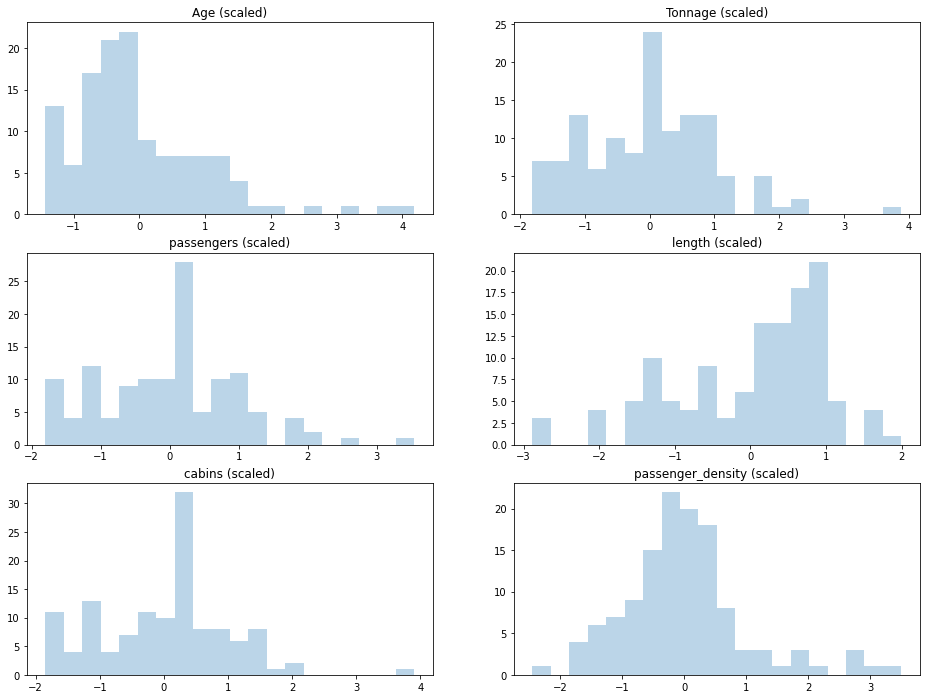

In [22]:
fig, axes = plt.subplots(3, 2)
for i, feature in enumerate(num_cols):
    ax = axes[i // 2, i % 2]
    ax.hist(X_train_num_prep[:, i], bins=20, alpha=0.3)
    ax.set_title(f"{feature} (scaled)")

In [24]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_train_cat_prep = cat_encoder.fit_transform(sDF[cat_cols])
X_train_cat_prep

<158x20 sparse matrix of type '<class 'numpy.float64'>'
	with 158 stored elements in Compressed Sparse Row format>

To make these easier to use I can build a `ColumnTransformer` to apply them at the same time

In [25]:
from sklearn.compose import ColumnTransformer

transform = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])


Now we can transform the whole training set

In [26]:
X_train_tr = transform.fit_transform(X_train)

In [27]:
X_train_tr

<126x26 sparse matrix of type '<class 'numpy.float64'>'
	with 882 stored elements in Compressed Sparse Row format>

## Training a model

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
model_lr = LinearRegression()

In [30]:
model_lr.fit(X_train_tr, y_train)

LinearRegression()

In [31]:
y_train_pred = model_lr.predict(X_train_tr)

In [32]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, model_lr.predict(X_train_tr))

0.730173879400047

I'm not supposed to be looking at the test data yet, but...

In [33]:
print(X_test.shape, X_train.shape)

(32, 7) (126, 7)


In [34]:
X_test_tr = transform.transform(X_test)


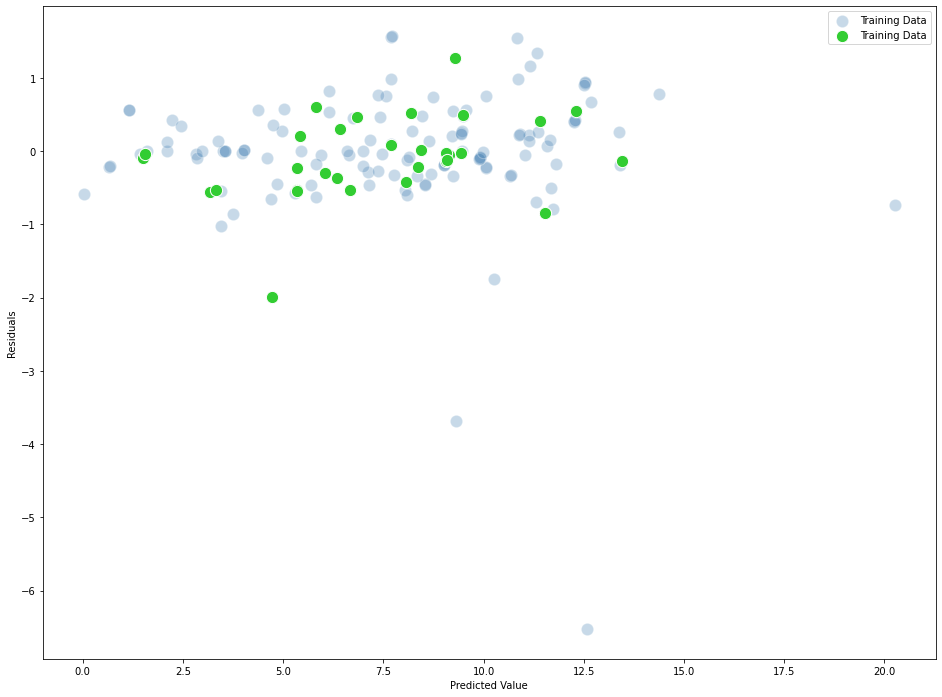

In [35]:
y_test_pred = model_lr.predict(X_test_tr)

# Plot residuals

fig, ax = plt.subplots()

ax.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c = 'steelblue',
    s = 150,
    marker='o',
    edgecolor='white',
    label='Training Data',
    alpha=0.3
)
ax.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c = 'limegreen',
    s = 150,
    marker='o',
    edgecolor='white',
    label='Training Data'
)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
ax.legend()

In [36]:
from sklearn.metrics import r2_score

In [37]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.730, test: 0.336
R^2 train: 0.945, test: 0.958


### PCA

Next we tried chaining together a principal component analysis (PCA) and the linear regression. We don't have many features here, but for more realistic problems, reducing the dimensionality might be very important. The `PCA` class doesn't like the sparse matrices returned by the `OneHotEncoder` so for now we focus on the floating point columns


In [38]:
from sklearn.decomposition import PCA

pca = PCA()

X_train_num_pca = pca.fit_transform(X_train_num_prep, y_train)

X_test_num_prep = num_encoder.transform(X_test[num_cols])
X_test_num_pca = pca.transform(X_test_num_prep)

The PCA class contains `explained_variance_ratio_` which returns the variance caused by each of the principal components

In [39]:
pca.explained_variance_ratio_

array([0.69249652, 0.20891936, 0.07026606, 0.02031425, 0.00472778,
       0.00327603])

This says that the last two principal components cause less than 1% of the variance. We decide to retain the first 4 as components as an example

same idea...

Now we can try pipelineing 

In [42]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('pca', PCA(n_components=4))
])

transform_full = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_cols),
    ('num', num_pipeline, num_cols),
])

In [43]:
X_train_tr = transform_full.fit_transform(X_train)
model_lr = LinearRegression()
model_lr.fit(X_train_tr, y_train)

LinearRegression()

In [44]:
y_train_pred = model_lr.predict(X_train_tr)
mean_squared_error(y_train, y_train_pred)

0.9121991412168496

## Cross Validation

Before looking at the test data, we can try to determine how reliable this error is by calculating a cross validation score. In k-fold cross validation, the data is partitioned into k discrete sets. Each of these sets is held back in turn and used to test the model trained on the $k-1$ other folds. 

In [45]:
from sklearn.model_selection import cross_val_score

In [46]:
scores = cross_val_score(model_lr, X_train_tr, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

print(f"{lin_rmse_scores.mean()} += {lin_rmse_scores.std()}")

1.0200116262337016 += 0.5007395704606644


## Other Models


### RandomForestRegressor
Next we tried some other models with the same workflow

In [47]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_tr, y_train)

scores = cross_val_score(forest_reg, X_train_tr, y_train,
                         scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-scores)

print(f"{forest_rmse_scores.mean()} += {forest_rmse_scores.std()}")

1.141275950377338 += 0.6891476228884775


### Lasso

In [48]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.7)

lasso.fit(X_train_tr,y_train)

scores = cross_val_score(lasso, X_train_tr, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lasso_rmse_scores = np.sqrt(-scores)

print(f"{lasso_rmse_scores.mean()} += {lasso_rmse_scores.std()}")


1.2117648544726 += 0.5096245993449966
